# LSTM을 사용하여 November 2015 판매량 예측
- 참고: A beginner guide for sale data prediction] 
- https://www.kaggle.com/minhtriet/a-beginner-guide-for-sale-data-prediction

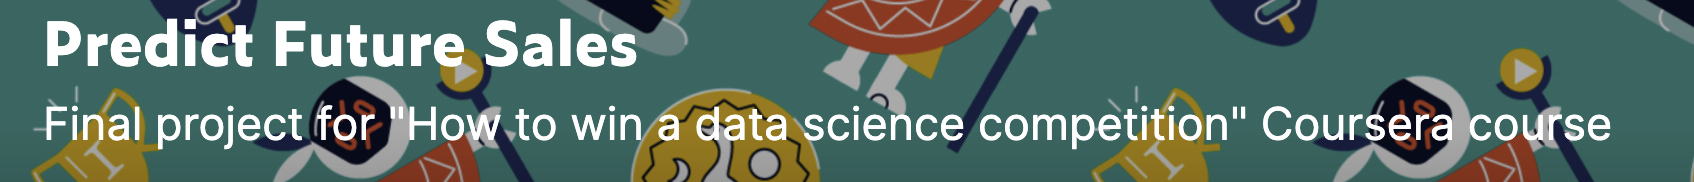

## train 데이터
ID -  (Shop, Item)를 구분  
shop_id   
item_id  
item_category_id  
item_cnt_day - 판매량, 월별 예측이 목적변수임  
item_price - 현재 가격  
date - dd/mm/yyyy  
date_block_num - 월 순서번호 2013.1월이 0, 2015.10월이 33  
item_name - 상품명  
shop_name - 상점명  
item_category_name - 카테고리명  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hwa-kim/opt/anaconda3/lib/pytho

In [ ]:
# !curl -L https://bit.ly/3aNJ9dG -o shop.zip
# !unzip shop.zip

In [2]:
path = "./competitive-data-science-predict-future-sales"

In [45]:
train=pd.read_csv(path+"/sales_train.csv")
item_cats=pd.read_csv(path+"/item_categories.csv")
items=pd.read_csv(path+"/items.csv")
submission=pd.read_csv(path+"/sample_submission.csv")
shops=pd.read_csv(path+"/shops.csv")
test=pd.read_csv(path+"/test.csv")

### 테스트 데이터에 있는 상점과 품목만 훈련에 사용

In [23]:
test.shape, train.shape

((214200, 3), (2935849, 6))

In [24]:
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [25]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [26]:
item_cats[:3]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [27]:
items[:3]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [28]:
shops[:3]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [29]:
len(test.shop_id.unique()), len(train.shop_id.unique())

(42, 60)

In [30]:
len(test.item_id.unique()), len(train.item_id.unique())

(5100, 21807)

In [46]:
test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]

In [32]:
len(test.shop_id.unique()), len(train.shop_id.unique())

(42, 42)

In [33]:
len(test.item_id.unique()), len(train.item_id.unique())

(5100, 4716)

In [35]:
test.shape, train.shape

((214200, 3), (1224439, 6))

In [36]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

In [37]:
print(MAX_BLOCK_NUM); print(MAX_ITEM); print(MAX_CAT)
print(MAX_SHOP)

33
5100
84
42


## EDA - 상점과 상품 관점


In [38]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])
                       ['item_cnt_day'].sum().reset_index())

In [47]:
train.shape, grouped.shape

((1224439, 6), (1327, 3))

In [40]:
grouped[:3]

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0


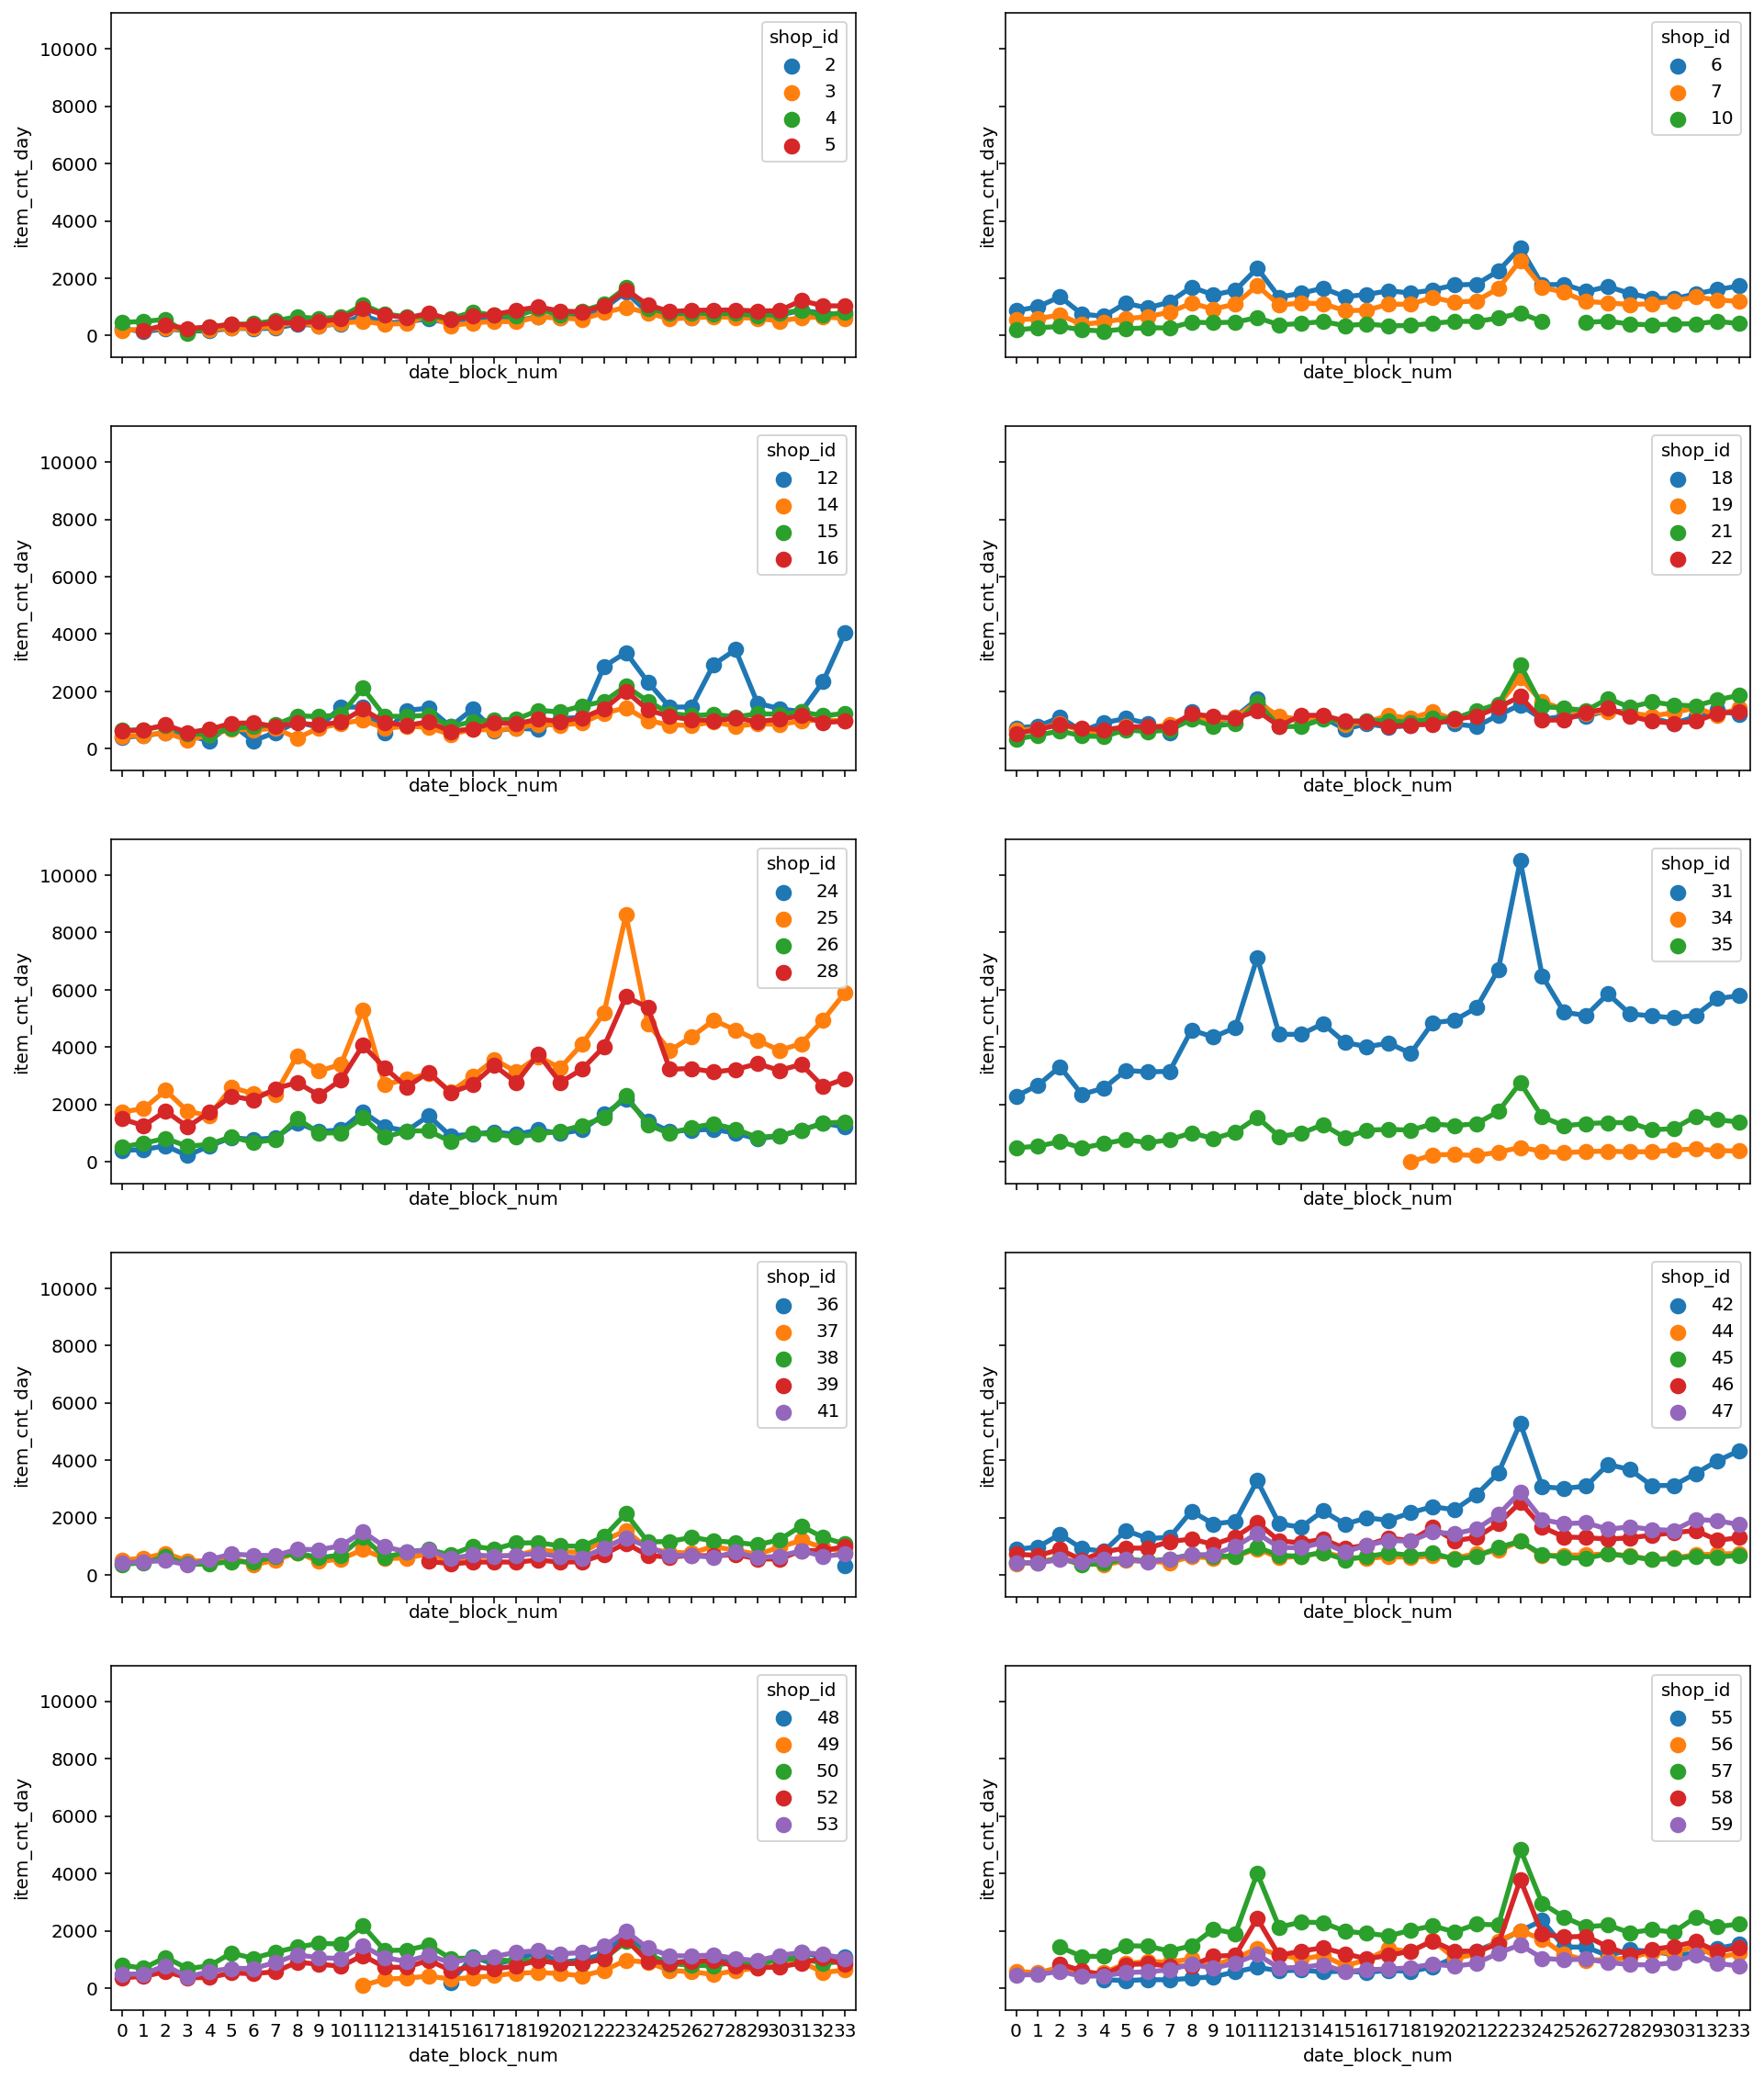

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', 
            hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], 
            grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

- 연말에 매출이 많다. 월 정보를 사용해야 한다
- 아이템보다 아이템 카테고리별 정보를 보겠다

In [48]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0


In [52]:
items[:3]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [53]:
train.set_index('item_id')[:3]

,date,date_block_num,shop_id,item_price,item_cnt_day
item_id,,,,,
22154,02.01.2013,0,59,999.0,1.0
2574,03.01.2013,0,25,399.0,2.0
2574,05.01.2013,0,25,399.0,1.0


In [55]:
train.set_index('item_id').join(items.set_index('item_id'))[:3]

,date,date_block_num,shop_id,item_price,item_cnt_day,item_name,item_category_id
item_id,,,,,,,
30,28.02.2013,1,50,399.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,26.02.2013,1,50,399.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,12.02.2013,1,50,399.0,1.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40


In [56]:
# 카테고리 추가
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train[:3]

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id
0,30,28.02.2013,1,50,399.0,1.0,40
1,30,26.02.2013,1,50,399.0,1.0,40
2,30,12.02.2013,1,50,399.0,1.0,40


In [57]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

In [58]:
train[:3]

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,30,28.02.2013,1,50,399.0,1.0,40,02,2013
1,30,26.02.2013,1,50,399.0,1.0,40,02,2013
2,30,12.02.2013,1,50,399.0,1.0,40,02,2013


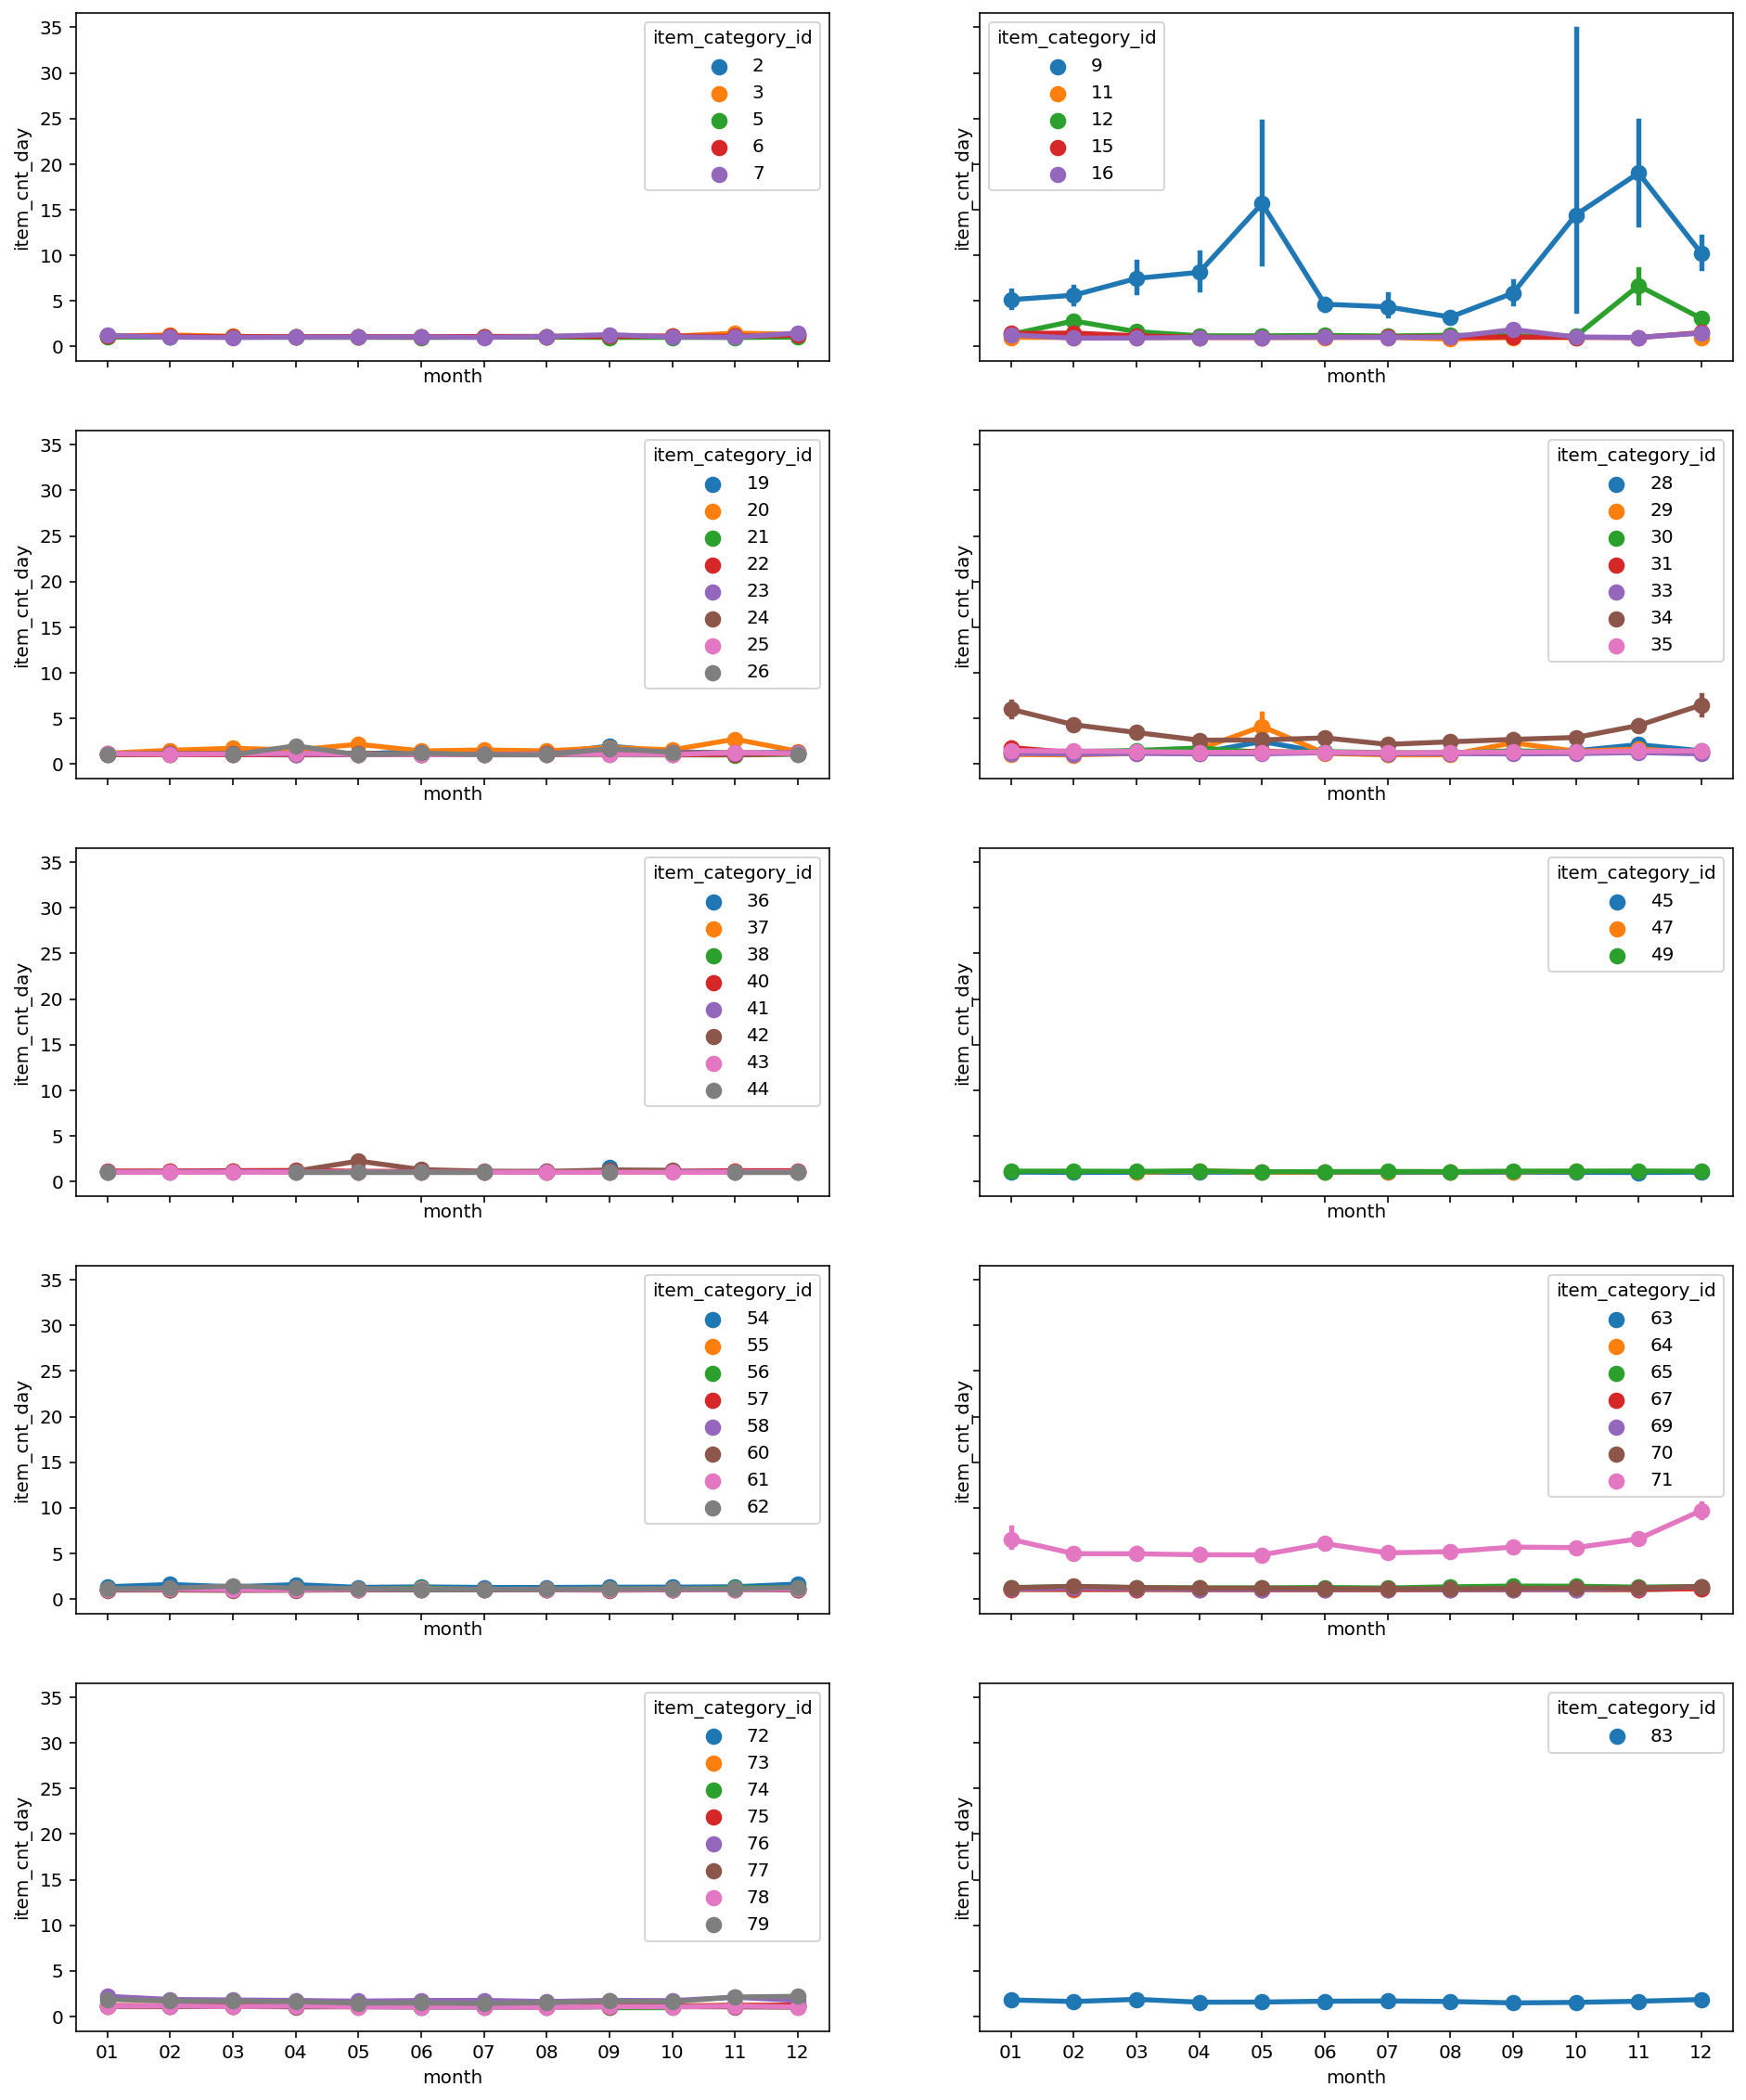

In [59]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

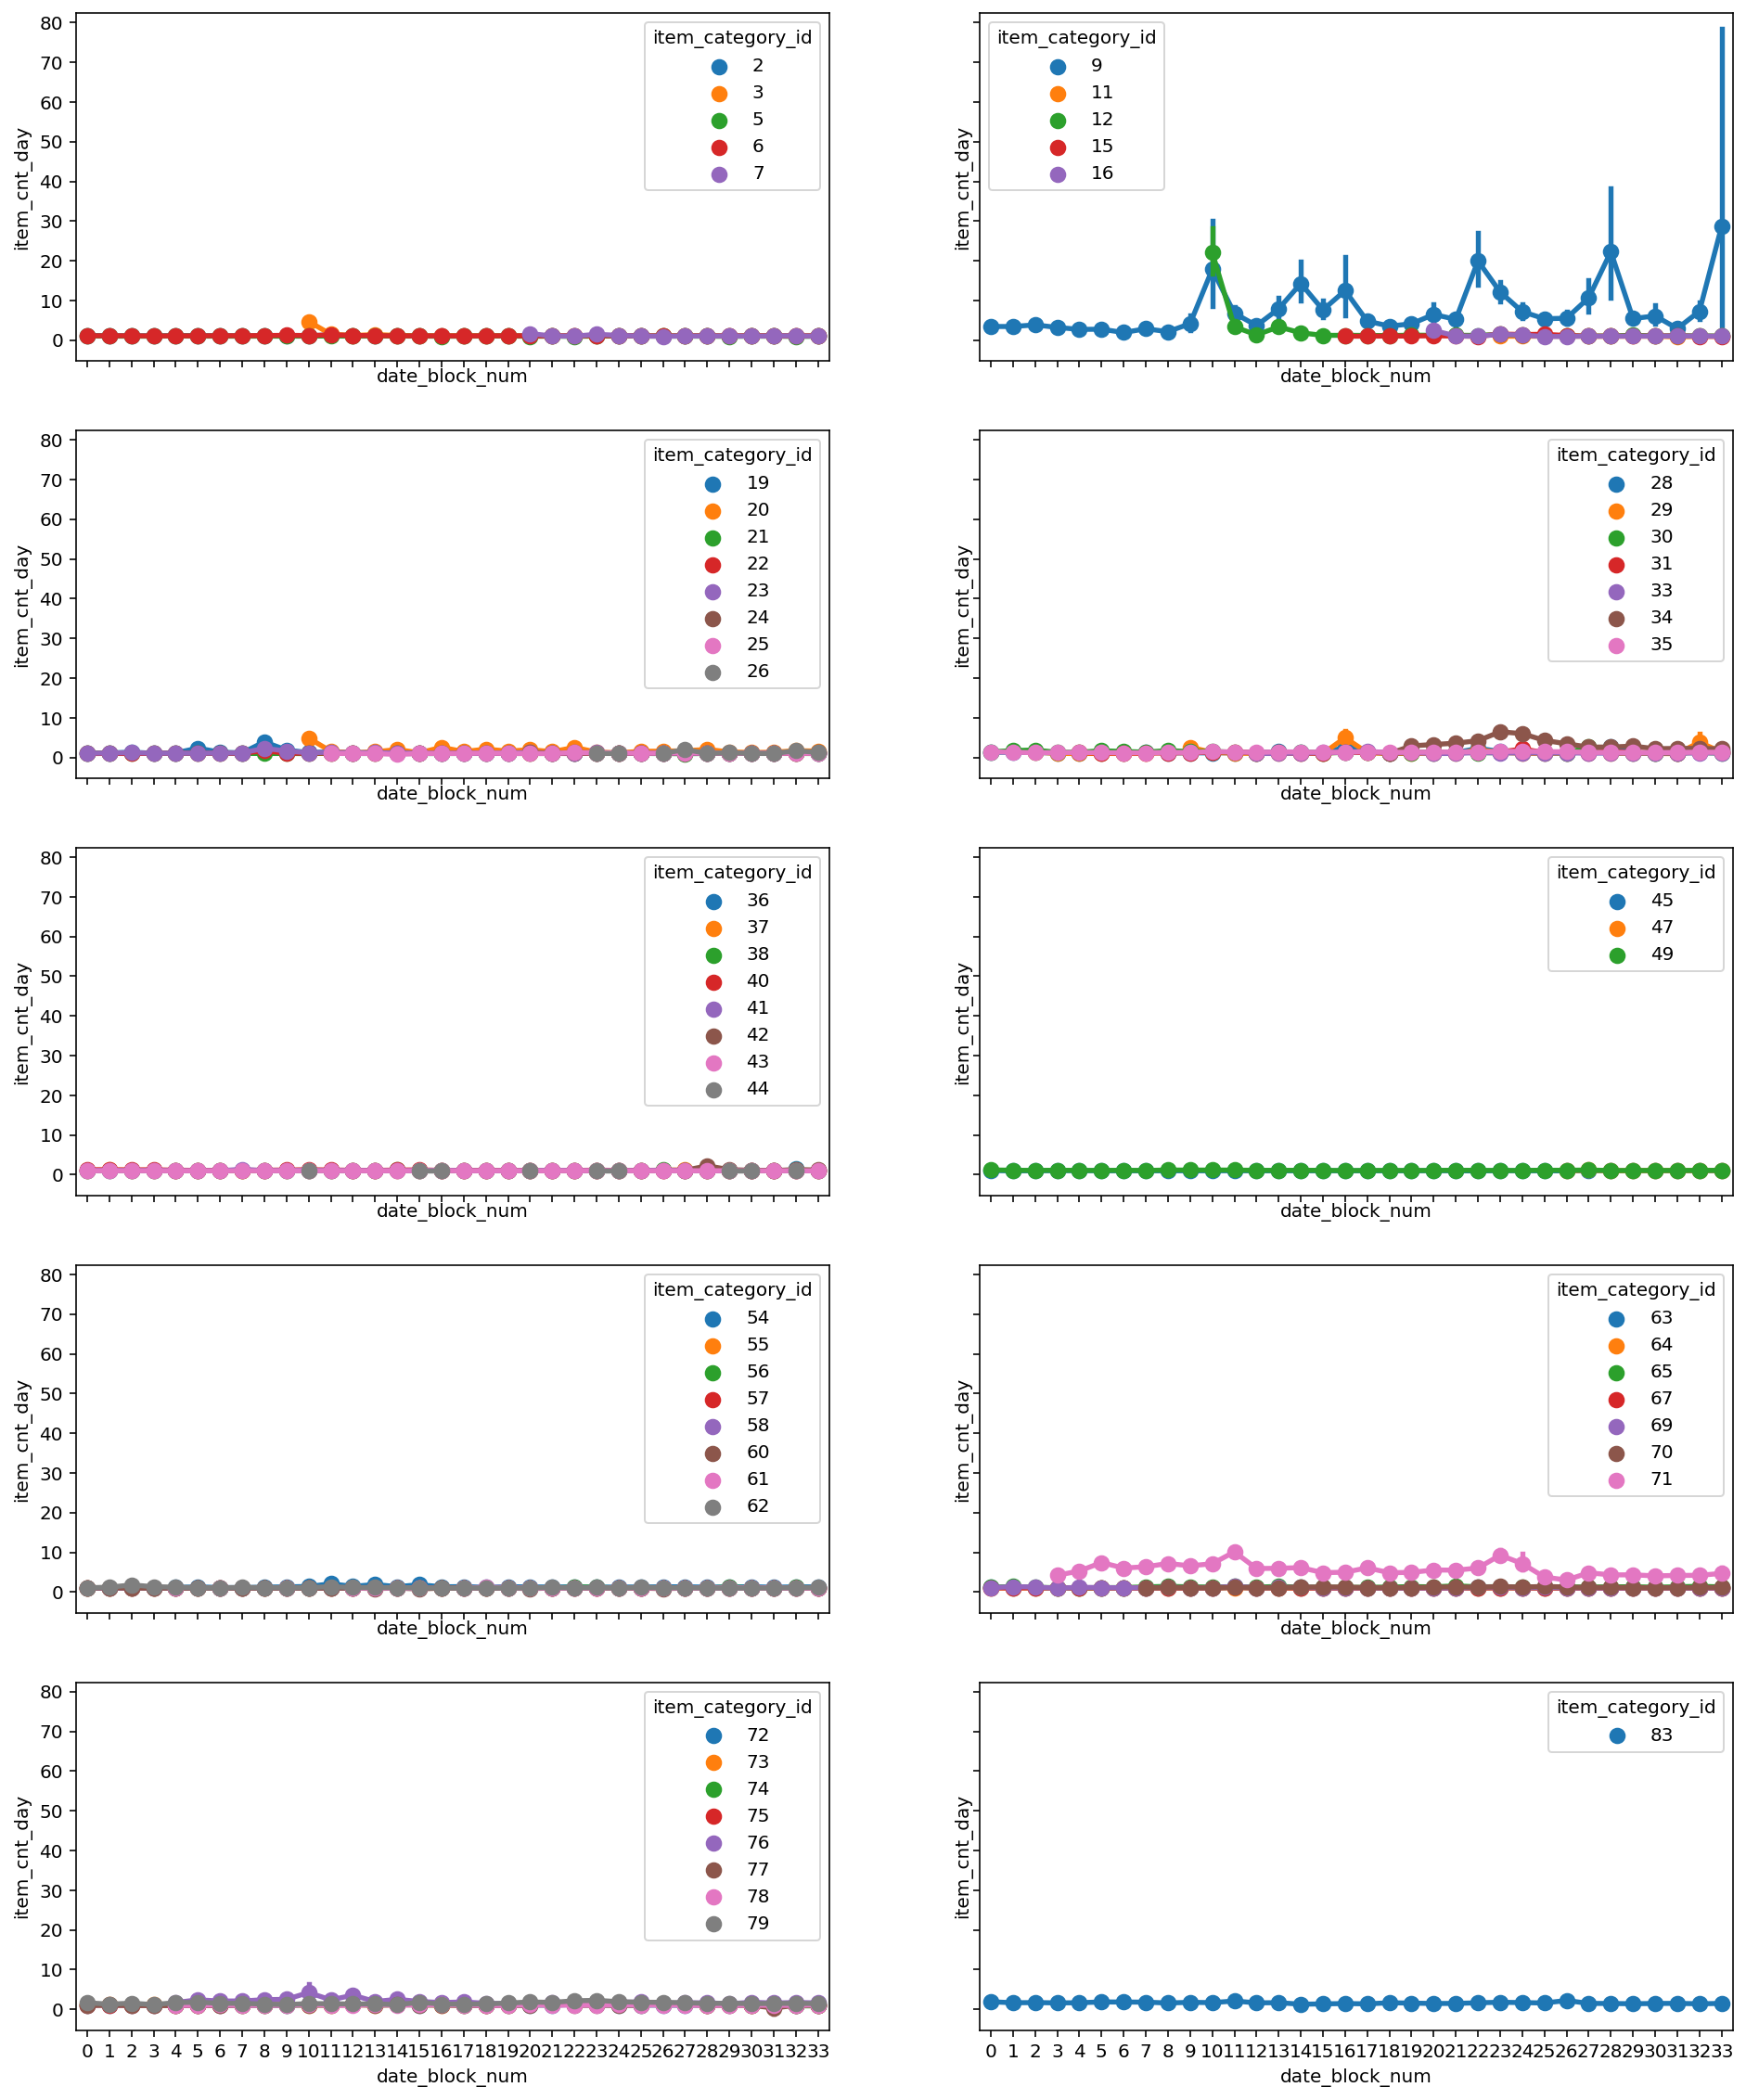

In [60]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [61]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

# 훈련
- 스케일링

In [63]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.values.reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.values.reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.values.reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.values.reshape(-1, 1))

- 2013. 1 부터의 데이터를 사용하지 않고 7월~11월 데이터만 사용하겠다

##  결측치 처리
- `item_cnt_day`이 없는 경우 0으로 처리
- `price` 가 없는 경우 상점과 시간마다 다를 수 있으므로 가장 가까운 과거의 가격으로 처리

In [64]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30      1              3         -0.072265      0.115543
                       4          0.041532      0.381274
                       5         -0.072265      0.204120
                       6          0.314142      2.241392
                       7          0.149626      0.647005
...                                    ...           ...
22167   33             28        -0.257221     -0.150189
                       37        -0.257221     -0.150189
                       42        -0.171945      0.115543
                       47        -0.257221     -0.150189
                       50        -0.257221     -0.150189

[600159 rows x 2 columns]

- 그루핑의 순서 변경

In [65]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

- 함수 정의

In [66]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [69]:
assert closest_date_block(18, 30, 5) == 18

In [70]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


- 어떤 블록을 학습시킬지 찾는다

In [71]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

In [72]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [73]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

Next, we would transform categorical value to their one-hot encoding version

In [74]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [75]:
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [76]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization...
Vectorization...
Vectorization...


In [77]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

Build model...

Epoch 1/13
111404/111404 [==============================] - 34s 301us/step - loss: 0.0910
Epoch 2/13
111404/111404 [==============================] - 32s 286us/step - loss: 0.0731
Epoch 3/13
111404/111404 [==============================] - 31s 276us/step - loss: 0.0632
Epoch 4/13
111404/111404 [==============================] - 29s 260us/step - loss: 0.0574
Epoch 5/13
111404/111404 [==============================] - 28s 256us/step - loss: 0.0618
Epoch 6/13
111404/111404 [==============================] - 30s 270us/step - loss: 0.0620
Epoch 7/13
111404/111404 [==============================] - 30s 266us/step - loss: 0.0470
Epoch 8/13
111404/111404 [==============================] - 29s 257us/step - loss: 0.0467
Epoch 9/13
111404/111404 [==============================] - 28s 250us/step - loss: 0.0371
Epoch 10/13
111404/111404 [==============================] - 30s 267us/step - loss: 0.0388
Epoch 11/13
111404/111404 [==============================] - 30s 267us/step - loss:

Below is the evaluation code for the model. For the speed of the kernel, I have commented them, but you can still find the result at the end of the cell

In [78]:
#import math
#from sklearn.metrics import mean_squared_error

# make predictions
#predict_train = model.predict(x_train)
#predict_val = model.predict(x_val)
# invert predictions
#predict_train = cnt_scaler.inverse_transform(predict_train)
#y_train = cnt_scaler.inverse_transform(y_train)
#predict_val = cnt_scaler.inverse_transform(predict_val)
#y_val = cnt_scaler.inverse_transform(y_val)
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
#print('Train Score: %.2f RMSE' % (trainScore))
#valScore = math.sqrt(mean_squared_error(predict_val, y_val))
#print('Test Score: %.2f RMSE' % (valScore))
#For 1 epoch
#Train Score: 3.85 RMSE
#Test Score: 4.29 RMSE

The learning seems to converge. We will then incrementally train on the validation set ([why does it work](https://github.com/keras-team/keras/issues/4446#issuecomment-261804574))

In [79]:
model.fit(x_val, y_val, batch_size=128, epochs=13)

Epoch 1/13
111404/111404 [==============================] - 46s 410us/step - loss: 0.0071
Epoch 2/13
111404/111404 [==============================] - 33s 300us/step - loss: 0.0083
Epoch 3/13
111404/111404 [==============================] - 28s 255us/step - loss: 0.0065
Epoch 4/13
111404/111404 [==============================] - 28s 250us/step - loss: 0.0079
Epoch 5/13
111404/111404 [==============================] - 28s 251us/step - loss: 0.0078
Epoch 6/13
111404/111404 [==============================] - 28s 253us/step - loss: 0.0052
Epoch 7/13
111404/111404 [==============================] - 28s 250us/step - loss: 0.0062
Epoch 8/13
111404/111404 [==============================] - 28s 249us/step - loss: 0.0056
Epoch 9/13
111404/111404 [==============================] - 28s 250us/step - loss: 0.0066
Epoch 10/13
111404/111404 [==============================] - 29s 256us/step - loss: 0.0059
Epoch 11/13
111404/111404 [==============================] - 29s 260us/step - loss: 0.0050
Epoch 12

# Inference
With everything prepared, let's moved to the inference part

In [80]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [81]:
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [82]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [83]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission.csv', index=False)